In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR, Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
import matplotlib.pyplot as plt
from sklearn.utils import resample
import os
%matplotlib inline

from models import *
from utils import *
np.random.seed(0)


In [2]:
# Create data
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)

# Compute z
z = FrankeFunction(x, y)

# Create features as pairs of (x, y)
features = np.stack([x.ravel(), y.ravel()], axis=1)


# Get labels
labels = z.ravel()
labels = labels.reshape((-1,1))


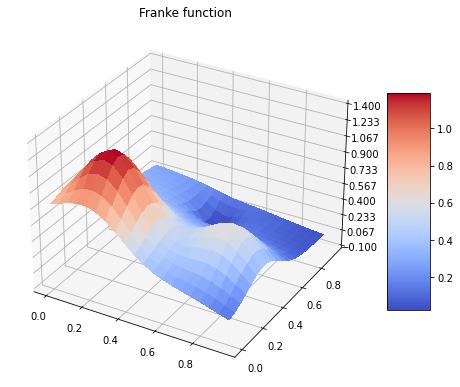

In [3]:
def plot_function(x, y, z, title=None):
    # Plot function
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if title is not None:
        plt.title(title)
    
    plt.show()
    
plot_function(x, y, z, 'Franke function')

In [4]:
def k_fold(X, y, k=[5],degree_of_polynomial=4, 
           scaling=False, solver=LinearRegression, **solver_args):
    
    
    test_mse=np.zeros((degree_of_polynomial-1, len(k)))
    
    for degree in range(1,degree_of_polynomial):
        #create pipeline for polynomial features and splitting over all polynomial degrees
        if scaling == True:
            data_model = make_pipeline(PolynomialFeatures(degree=degree), StandardScaler(with_std= True))
        else:
            data_model = make_pipeline(PolynomialFeatures(degree=degree))
        
        X_d = data_model.fit_transform(X)
        y_d = y
        
        # repeat for all k 
        for f_n, fold_f in enumerate(k ):
            # split the data into k folds
            k_fold= KFold(n_splits=fold_f)
            fold_f_mse=0.0
            #train on (fold_f-1) folds and test on the left out fold
            if solver == LinearRegression or solver == RidgeRegression or solver== Lasso:
                for nk, (train_index, test_index) in enumerate(k_fold.split(X_d)):
                    x_train, x_test = X_d[train_index], X_d[test_index]
                    y_train, y_test = y_d[train_index], y_d[test_index]
                    if solver in [LinearRegression, RidgeRegression]:
                        model = solver(**solver_args, dimension=x_train.shape)                    
                        # evaluate mse on left out fold
                        model.fit(x_train, y_train)
                        y_hat_test=model.predict(x_test)
                    else:
                        model = solver(**solver_args)
                        y_hat_test= model.fit(x_train, y_train).predict(x_test)
                    
                    mse_local = MSE(y_hat_test, y_test)
                    fold_f_mse+=mse_local

                fold_f_mse/=fold_f
            
            else:
                model= solver(**solver_args)
                fold_f_mse=-cross_val_score(model, X_d, y_d, scoring='neg_mean_squared_error', cv=fold_f)
                fold_f_mse=np.mean(fold_f_mse)
                
            test_mse[degree-1, f_n]=fold_f_mse
                      
        
    return test_mse      
    

#### Cross validation -1

Here we examine the kfold cross-validation without noise and without scaling

(9, 6)


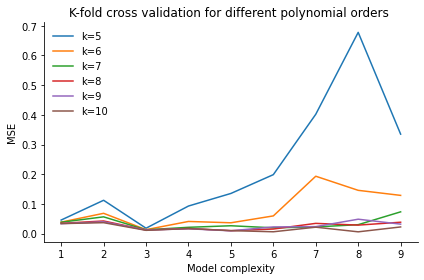

<AxesSubplot:title={'center':'K-fold cross validation for different polynomial orders '}, xlabel='Model complexity', ylabel='MSE'>

In [5]:
degree_of_polynomial=10
k=[5, 6, 7, 8, 9, 10]

add_noise= False
if add_noise :
    np.random.seed(1)
    labels_n = labels +  np.random.normal(0 , 1, labels.shape )
else :
    labels_n = labels
    
#define the input argumets for the solver 
solver_args ={ 'fit_intercept': True }


t= k_fold(features, labels_n, k=k,degree_of_polynomial=degree_of_polynomial, 
           scaling= False, solver=LinearRegression, **solver_args)
print(t.shape)

polynomial=np.arange(1, degree_of_polynomial)

title = 'K-fold cross validation for different polynomial orders '
plot_metric(y= t.T, x= polynomial, show= True, title=title , name='c_without_noise_without_scaling_.png', x_label='Model complexity', y_label='MSE',  save=True, legend = ['k=5','k=6', 'k=7', 'k=8', 'k=9', 'k=10'])

#### Cross validation - 2

Here we examine the kfold cross-validation without noise and with scaling

(9, 6)


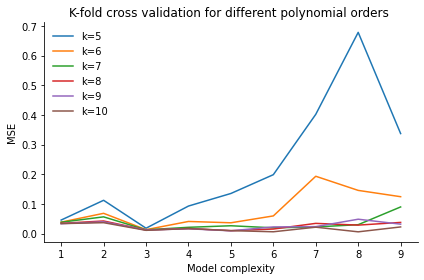

<AxesSubplot:title={'center':'K-fold cross validation for different polynomial orders '}, xlabel='Model complexity', ylabel='MSE'>

In [6]:
degree_of_polynomial=10

k=[5, 6, 7, 8, 9, 10]

add_noise= False
if add_noise :
    np.random.seed(1)
    labels_n = labels +  np.random.normal(0 , 1, labels.shape )
else :
    labels_n = labels
    
#define the input argumets for the solver 
solver_args ={ 'fit_intercept': True }


t= k_fold(features, labels_n, k=k,degree_of_polynomial=degree_of_polynomial, 
           scaling= True, solver=LinearRegression, **solver_args)
print(t.shape)

polynomial=np.arange(1, degree_of_polynomial)
title = 'K-fold cross validation for different polynomial orders '
plot_metric(y= t.T, x= polynomial, show= True, title=title , name='c_without_noise_with_scaling_.png', x_label='Model complexity', y_label='MSE',  save=True, legend = ['k=5','k=6', 'k=7', 'k=8', 'k=9', 'k=10'])
    

#### Cross validation -3

Here we examine the kfold cross-validation with noise and with scaling

(9, 6)
[[1.04759816e+00 1.03621876e+00 1.03795371e+00 1.03080425e+00
  1.03235299e+00 1.03504525e+00]
 [1.08591581e+00 1.04989276e+00 1.08745607e+00 1.07069070e+00
  1.06315470e+00 1.06162568e+00]
 [1.07683354e+00 1.06764979e+00 1.03957293e+00 1.04108477e+00
  1.04012806e+00 1.03315463e+00]
 [1.54945564e+00 1.24732393e+00 1.31723977e+00 1.37701040e+00
  1.28059704e+00 1.09536324e+00]
 [3.10272613e+00 1.39434358e+00 2.20685684e+00 2.54751803e+00
  2.04617254e+00 1.28492129e+00]
 [1.15407235e+01 9.43694052e+00 5.51649001e+00 8.26717432e+00
  3.58628338e+00 1.31151288e+00]
 [2.11108170e+02 5.76409592e+01 2.99334980e+01 2.83899135e+01
  9.97234313e+00 1.63018739e+00]
 [1.42725625e+03 3.48788934e+02 5.99065298e+01 6.91128242e+01
  2.87287980e+01 2.26789442e+01]
 [8.75917674e+03 1.39157778e+03 1.27712045e+02 2.11770483e+02
  7.44998969e+00 4.28293362e+01]]


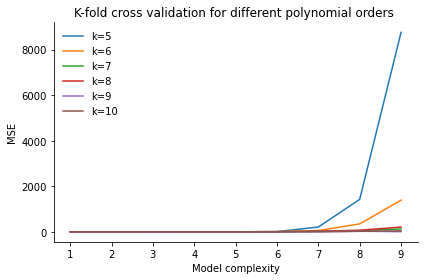

<AxesSubplot:title={'center':'K-fold cross validation for different polynomial orders '}, xlabel='Model complexity', ylabel='MSE'>

In [7]:
degree_of_polynomial=10
k=[5, 6, 7, 8, 9, 10]

add_noise= True
if add_noise :
    np.random.seed(1)
    labels_n = labels +  np.random.normal(0 , 1, labels.shape )
else :
    labels_n = labels
    
#define the input argumets for the solver 
solver_args ={ 'fit_intercept': True }


t= k_fold(features, labels_n, k=k,degree_of_polynomial=degree_of_polynomial, 
           scaling= True, solver=LinearRegression, **solver_args)
print(t.shape)
print(t)

polynomial=np.arange(1, degree_of_polynomial)
title = 'K-fold cross validation for different polynomial orders '
plot_metric(y= t.T, x= polynomial, show= True, title=title , name='c_with_noise_with_scaling_.png', x_label='Model complexity', y_label='MSE',  save=True, legend = ['k=5','k=6', 'k=7', 'k=8', 'k=9', 'k=10'])
    

## Compare case-3 with scikit learn implementation

(9, 6)
[[1.04759816e+00 1.03621876e+00 1.03795371e+00 1.03080425e+00
  1.03235299e+00 1.03504525e+00]
 [1.08591581e+00 1.04989276e+00 1.08745607e+00 1.07069070e+00
  1.06315470e+00 1.06162568e+00]
 [1.07683354e+00 1.06764979e+00 1.03957293e+00 1.04108477e+00
  1.04012806e+00 1.03315463e+00]
 [1.54945564e+00 1.24732393e+00 1.31723977e+00 1.37701040e+00
  1.28059704e+00 1.09536324e+00]
 [3.10272612e+00 1.39434358e+00 2.20685684e+00 2.54751803e+00
  2.04617254e+00 1.28492129e+00]
 [2.18604314e+01 1.92959737e+01 5.28359020e+00 2.68881108e+00
  5.29670948e+00 2.37467980e+00]
 [2.51850065e+02 1.07369201e+02 8.55219076e+01 7.55114202e+01
  3.01278300e+01 1.04261878e+01]
 [2.90095996e+03 6.57195629e+02 7.44964991e+01 8.46130918e+01
  5.78101970e+01 4.16233195e+01]
 [1.58882390e+04 6.31330599e+02 2.06843783e+02 2.17398310e+02
  1.01190254e+02 8.97984945e+01]]


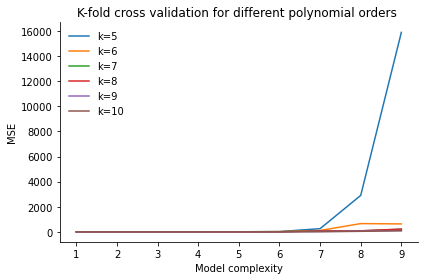

<AxesSubplot:title={'center':'K-fold cross validation for different polynomial orders '}, xlabel='Model complexity', ylabel='MSE'>

In [8]:
degree_of_polynomial=10
k=[5, 6, 7, 8, 9, 10]

add_noise= True
if add_noise :
    np.random.seed(1)
    labels_n = labels +  np.random.normal(0 , 1, labels.shape )
else :
    labels_n = labels
    
#define the input argumets for the solver 
solver_args ={ 'fit_intercept': True }


t= k_fold(features, labels_n, k=k,degree_of_polynomial=degree_of_polynomial, 
           scaling= True, solver=LR, **solver_args)
print(t.shape)
print(t)

polynomial=np.arange(1, degree_of_polynomial)
title = 'K-fold cross validation for different polynomial orders '
plot_metric(y= t.T, x= polynomial, show= True, title=title , name='c_with_noise_with_scaling_scikit.png', x_label='Model complexity', y_label='MSE',  save=True, legend = ['k=5','k=6', 'k=7', 'k=8', 'k=9', 'k=10'])
    